In [1]:
%matplotlib inline
import pydicom
import numpy as np # linear algebra
import os
import open3d as o3d
import scipy
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

dicomdir_path="/home/qiwen/Documents/CT_Daten/Case WM/2023-08-24-002/DICOMDIR"
images_folder="/home/qiwen/Documents/CT_Daten/Case WM/2023-08-24-002/IMAGES"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dicomdir = pydicom.dcmread(dicomdir_path)

# 查看DICOMDIR中的患者信息
for patient_record in dicomdir.patient_records:
    print(f"Patient ID: {patient_record.PatientID}")
    print(f"Patient Name: {patient_record.PatientName}")

    # 获取该患者的所有影像记录
    studies = patient_record.children
    for study in studies:
        print(f"Study Date: {study.StudyDate}")
        print(f"Study Description: {study.StudyDescription}")

        # 获取影像序列记录
        series = study.children
        for serie in series:
            print(f"Series Description: {serie.SeriesDescription}")
            print(f"Modality: {serie.Modality}")
            
            # 获取每个序列中的所有影像文件
            instances = serie.children
            for instance in instances:
                print(f"Instance File: {instance.ReferencedFileID}")


Patient ID: e9bf22e6
Patient Name: De-identified
Study Date: 20190117
Study Description: CT Nasennebenhoehlen
Series Description: KIEFER KN 0.625 REF.
Modality: CT
Instance File: ['IMAGES', 'IM00001']
Instance File: ['IMAGES', 'IM00002']
Instance File: ['IMAGES', 'IM00003']
Instance File: ['IMAGES', 'IM00004']
Instance File: ['IMAGES', 'IM00005']
Instance File: ['IMAGES', 'IM00006']
Instance File: ['IMAGES', 'IM00007']
Instance File: ['IMAGES', 'IM00008']
Instance File: ['IMAGES', 'IM00009']
Instance File: ['IMAGES', 'IM00010']
Instance File: ['IMAGES', 'IM00011']
Instance File: ['IMAGES', 'IM00012']
Instance File: ['IMAGES', 'IM00013']
Instance File: ['IMAGES', 'IM00014']
Instance File: ['IMAGES', 'IM00015']
Instance File: ['IMAGES', 'IM00016']
Instance File: ['IMAGES', 'IM00017']
Instance File: ['IMAGES', 'IM00018']
Instance File: ['IMAGES', 'IM00019']
Instance File: ['IMAGES', 'IM00020']
Instance File: ['IMAGES', 'IM00021']
Instance File: ['IMAGES', 'IM00022']
Instance File: ['IMAGE

In [3]:
print(dicomdir)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Media Storage Directory Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.45.1.7.4.929342982293.23082415264900002.11292
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.45.1.1.0.71.20130122
(0002, 0013) Implementation Version Name         SH: 'DicomWeb_71'
-------------------------------------------------
(0004, 1130) File-set ID                         CS: 'VISAGECS_MEDIA'
(0004, 1200) Offset of the First Directory Recor UL: 404
(0004, 1202) Offset of the Last Directory Record UL: 404
(0004, 1212) File-set Consistency Flag           US: 0
(0004, 1220)  Directory Record Sequence  1291 item(s) ---- 
   (0004, 1400) Offset of the Next Directory Record UL:

In [4]:
def get_series_by_SeriesNumber(study, target_SeriesNumber):
    """
    从 study 中查找指定 SeriesNumber 的序列。
    
    参数:
        study: 目标研究对象
        target_SeriesNumber: 要查找的 SeriesNumber
    
    返回:
        series: 匹配的 series 对象，找不到返回 None
    """
    for series in study.children:
        series_number = series.SeriesNumber
        if series_number == target_SeriesNumber:
            return series
    return None

In [5]:
def get_study_by_id(dicomdir_path, target_study_id):
    """
    从 DICOMDIR 中查找指定 Study ID 的研究记录。
    
    参数:
        dicomdir_path: DICOMDIR 文件的路径
        target_study_id: 要查找的 StudyInstanceUID (Study ID)
    
    返回:
        study: 匹配的 study 对象，找不到返回 None
    """
    # 读取 DICOMDIR 文件
    dicomdir = pydicom.dcmread(dicomdir_path)
    
    # 遍历患者记录
    for patient_record in dicomdir.patient_records:
        # 遍历患者的检查记录
        for study in patient_record.children:
            # 获取当前 study 的 StudyID
            study_id = study.StudyID
            
            # 检查是否与目标 Study ID 匹配
            if study_id == target_study_id:
                return study
    
    # 如果未找到匹配的 Study ID
    return None

In [6]:
def load_scan_by_series(dicomdir_path, images_folder, target_study_id, target_SeriesNumber):
    """
    根据 Study ID 和 Series Description 加载特定序列的 DICOM 数据。
    
    参数:
        dicomdir_path: DICOMDIR 文件的路径
        images_folder: DICOM 图像文件所在的文件夹路径
        target_study_id: 要加载的 StudyInstanceUID (Study ID)
        target_SeriesNumber: 要加载的 SeriesNumber
    
    返回:
        slices: 排序后的 DICOM 切片数据
    """
    # 存储 DICOM 文件的路径和信息
    slices = []

    # 获取指定 Study ID 的研究
    study = get_study_by_id(dicomdir_path, target_study_id)
    if study is None:
        raise ValueError(f"未找到 Study ID 为 {target_study_id} 的数据。")

    # 获取指定 Series Description 的序列
    series = get_series_by_SeriesNumber(study, target_SeriesNumber)
    if series is None:
        raise ValueError(f"未找到 target_SeriesNumber 为 {target_SeriesNumber} 的数据。")

    # 遍历序列中的每个实例（影像文件）
    for instance in series.children:
        # 构建影像文件路径
        instance_path = os.path.join(images_folder, instance.ReferencedFileID[1])
        
        # 读取 DICOM 文件并添加到列表
        slices.append(pydicom.dcmread(instance_path))

    # 按 InstanceNumber 排序切片
    slices.sort(key=lambda x: int(x.InstanceNumber))
    return slices

In [7]:
def load_scan(dicomdir_path, images_folder):
    # 读取 DICOMDIR 文件
    dicomdir = pydicom.dcmread(dicomdir_path)
    
    # 存储 DICOM 文件的路径和信息
    slices = []

    # 遍历患者记录
    for patient_record in dicomdir.patient_records:
        # 遍历检查记录
        for study in patient_record.children:
            for series in study.children:
                # 遍历序列中的每个实例（影像文件）
                for instance in series.children:
                    instance_path = os.path.join(images_folder, instance.ReferencedFileID[1])
                    slices.append(pydicom.dcmread(instance_path))

    # 按 InstanceNumber 排序切片
    slices.sort(key=lambda x: int(x.InstanceNumber))
    return slices

In [8]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    slice_thickness = float(scan[0].SliceThickness)
    pixel_spacing = list(scan[0].PixelSpacing)
    spacing = np.array([slice_thickness] + pixel_spacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [9]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [10]:
def normlize_plot_open3d(image, threshold=-300):
    # Position the scan upright,
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2, 1, 0)
    
    verts, faces, _, _ = measure.marching_cubes(p, threshold)  # Notice the extra underscore for normals

    min_bound = verts.min(axis=0)  # [min_x, min_y, min_z]
    max_bound = verts.max(axis=0)  # [max_x, max_y, max_z]

    scale = max_bound - min_bound  # [scale_x, scale_y, scale_z]
    verts_norm = verts / scale
    
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(verts_norm)
    
    file_name="CT_point_cloud.ply"
    
    o3d.io.write_point_cloud(file_name, point_cloud)
    print(f"Point cloud saved to {file_name}")
    
    o3d.visualization.draw_geometries([point_cloud])

In [11]:
slices = load_scan_by_series(dicomdir_path, images_folder, target_study_id="9b1298b0", target_SeriesNumber="2")

In [12]:
print(f"Loaded {len(slices)} slices")

Loaded 602 slices


In [15]:
first_patient_pixels = get_pixels_hu(slices)

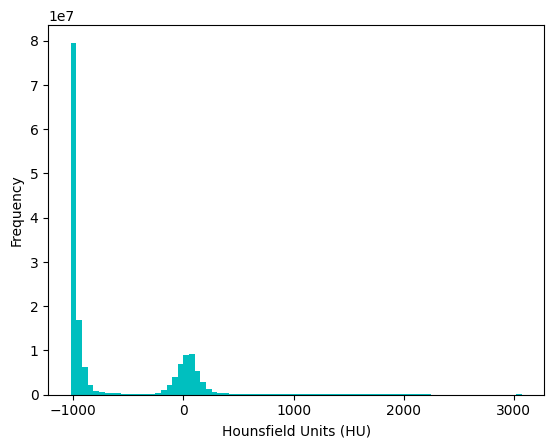

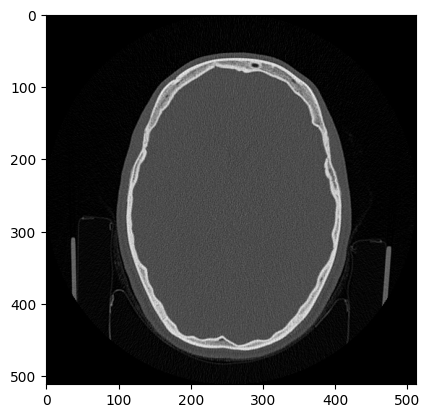

In [16]:
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[22], cmap=plt.cm.gray)
plt.show()

In [17]:
pix_resampled, spacing = resample(first_patient_pixels, slices, [2,2,2])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

/tmp/ipykernel_88348/2981627436.py:13: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')


Shape before resampling	 (602, 512, 512)
Shape after resampling	 (188, 118, 118)


In [18]:
normlize_plot_open3d(pix_resampled, 400)

Point cloud saved to CT_point_cloud.ply
